# Workers productivity

Contenido:
- Analisis de datos de la productividad de trabajadores.
- Modelo predictivo de la productividad de los trabajadores.

Importamos librerias necesarias

In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
from sklearn.metrics import accuracy_score,r2_score, mean_squared_error, mean_absolute_error, mean_squared_log_error

Leemos nuestros datos

In [2]:
df = pd.read_csv('garments_worker_productivity.csv')

In [3]:
df

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,01/01/2015,1,sweing,Thursday,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725
1,01/01/2015,1,finishing,Thursday,1,0.75,3.94,NaN,960,0,0.0,0,0,8.0,0.886500
2,01/01/2015,1,sweing,Thursday,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
3,01/01/2015,1,sweing,Thursday,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
4,01/01/2015,1,sweing,Thursday,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,0.800382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1192,03/11/2015,2,finishing,Wednesday,10,0.75,2.90,NaN,960,0,0.0,0,0,8.0,0.628333
1193,03/11/2015,2,finishing,Wednesday,8,0.70,3.90,NaN,960,0,0.0,0,0,8.0,0.625625
1194,03/11/2015,2,finishing,Wednesday,7,0.65,3.90,NaN,960,0,0.0,0,0,8.0,0.625625
1195,03/11/2015,2,finishing,Wednesday,9,0.75,2.90,NaN,1800,0,0.0,0,0,15.0,0.505889


Atributos del dataset:
1. **date**: Fecha en MM-DD-AAAA
3. **quarter**: Una parte del mes. Un mes se divide en cuatro trimestres
4. **department**: Departamento asociado
2. **day**: Día de la semana
5. **team**: Número de equipo asociado a la instancia
8. **targeted_productivity**: Objetivo de productividad fijado por la autoridad para cada equipo para cada día
9. **smv**: Valor estándar del minuto, es el tiempo asignado a una tarea 
10. **wip**: Trabajos en curso. Incluye el número de artículos sin terminar para los productos 
11. **over_time**: Representa la cantidad de tiempo extra de cada equipo en minutos
12. **incentive**: Representa el importe del incentivo financiero (en BDT) que permite o motiva una determinada acción
13. **idle_time**: La cantidad de tiempo en que la producción se interrumpió debido a varias razones 
14. **idle_men**: El número de trabajadores que estuvieron inactivos debido a la interrupción de la producción
7. **no_of_style_change**: Número de cambios en el estilo de un determinado producto
6. **no_of_workers**: Número de trabajadores en cada equipo
15. **actual_productivity**: Es el porcentaje real de productividad que han aportado los trabajadores. Va de 0 a 1.

# Analisis exploratorio

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   1197 non-null   object 
 1   quarter                1197 non-null   int64  
 2   department             1197 non-null   object 
 3   day                    1197 non-null   object 
 4   team                   1197 non-null   int64  
 5   targeted_productivity  1197 non-null   float64
 6   smv                    1197 non-null   float64
 7   wip                    691 non-null    float64
 8   over_time              1197 non-null   int64  
 9   incentive              1197 non-null   int64  
 10  idle_time              1197 non-null   float64
 11  idle_men               1197 non-null   int64  
 12  no_of_style_change     1197 non-null   int64  
 13  no_of_workers          1197 non-null   float64
 14  actual_productivity    1197 non-null   float64
dtypes: f

Veamos cuantos valores nulos tenemos

In [5]:
df.isnull().sum()

date                       0
quarter                    0
department                 0
day                        0
team                       0
targeted_productivity      0
smv                        0
wip                      506
over_time                  0
incentive                  0
idle_time                  0
idle_men                   0
no_of_style_change         0
no_of_workers              0
actual_productivity        0
dtype: int64

Veamos los tipos de departamentos

In [6]:
df['department'].value_counts()

sweing        691
finishing     257
finishing     249
Name: department, dtype: int64

Podemos ver que el mismo departamento por un error en la escritura lo toma como uno diferente

La descripcion nos dice que la productividad va de 0 - 1, veamos si hay valores que se salen de ese rango.

In [7]:
column = df['actual_productivity']
count = column[column > 1].count()
count 

37

## Data cleaning

Ahora fusionemos los dos departamentos de "finishing".

In [8]:
df['department'] = df['department'].apply(lambda x: 'finishing' if x.replace(" ","") == 'finishing' else 'sewing' )

Podemos ver que ahora ya tenemos los departamentos correctos

<AxesSubplot: ylabel='department'>

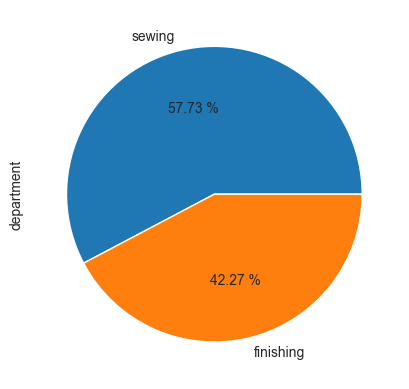

In [9]:
df.department.value_counts().plot.pie(autopct='%.2f %%')

### Saquemos algunas graficas

Comparemos la productividad real y la productividad objetivo para ver el rendimiento de los empleados.

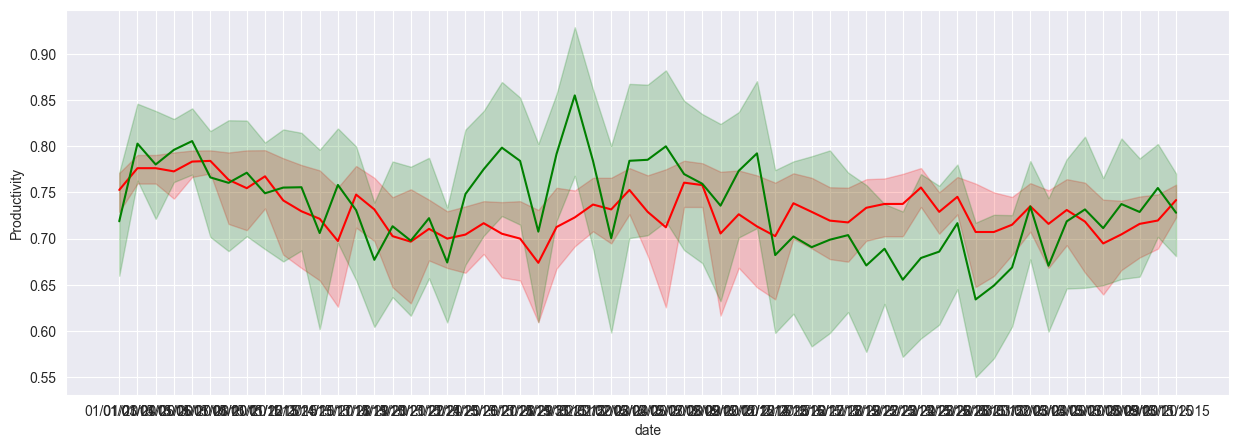

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize = (15,5))
ax=sns.lineplot(y='targeted_productivity',x='date' ,color = "red", data =df,legend='brief')
ax=sns.lineplot(y= 'actual_productivity',x='date',data=df, color="green", legend = 'brief')
ax.set(ylabel = 'Productivity')
plt.show()

Ahora analicemos si el día concreto de la semana o el equipo o el departamento tiene algún efecto significativo en la productividad.

Productividad en Thursday :  0.7226408815326634
Productividad en Saturday :  0.7519288593743317
Productividad en Sunday :  0.7286041288078818
Productividad en Monday :  0.7354884994170856
Productividad en Tuesday :  0.742700917676617
Productividad en Wednesday :  0.7304619085144229


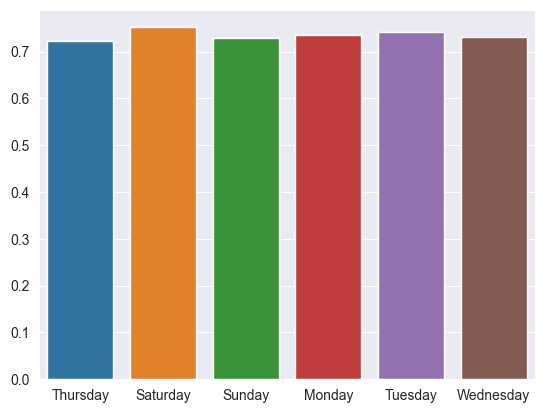

In [11]:
l = []
l1=[]
column_name = "day"
for i in list(df[column_name].unique()):
    print( f"Productividad en {i} : ",df[df[column_name] == i]["actual_productivity"].mean())
    l.append(df[df[column_name] == i]["actual_productivity"].mean())
    l1.append(i)
    dictionary = {"data":l,"keys":l1}
    sns.barplot( x = "keys" , y = "data", data = dictionary)
# plt.savefig('days.png')

Como podemos ver arriba, la productividad no depende del equipo, la categoría, el trimestre o el día.

Vamos a trazar la matriz de correlación para ver la cantidad de correlación -

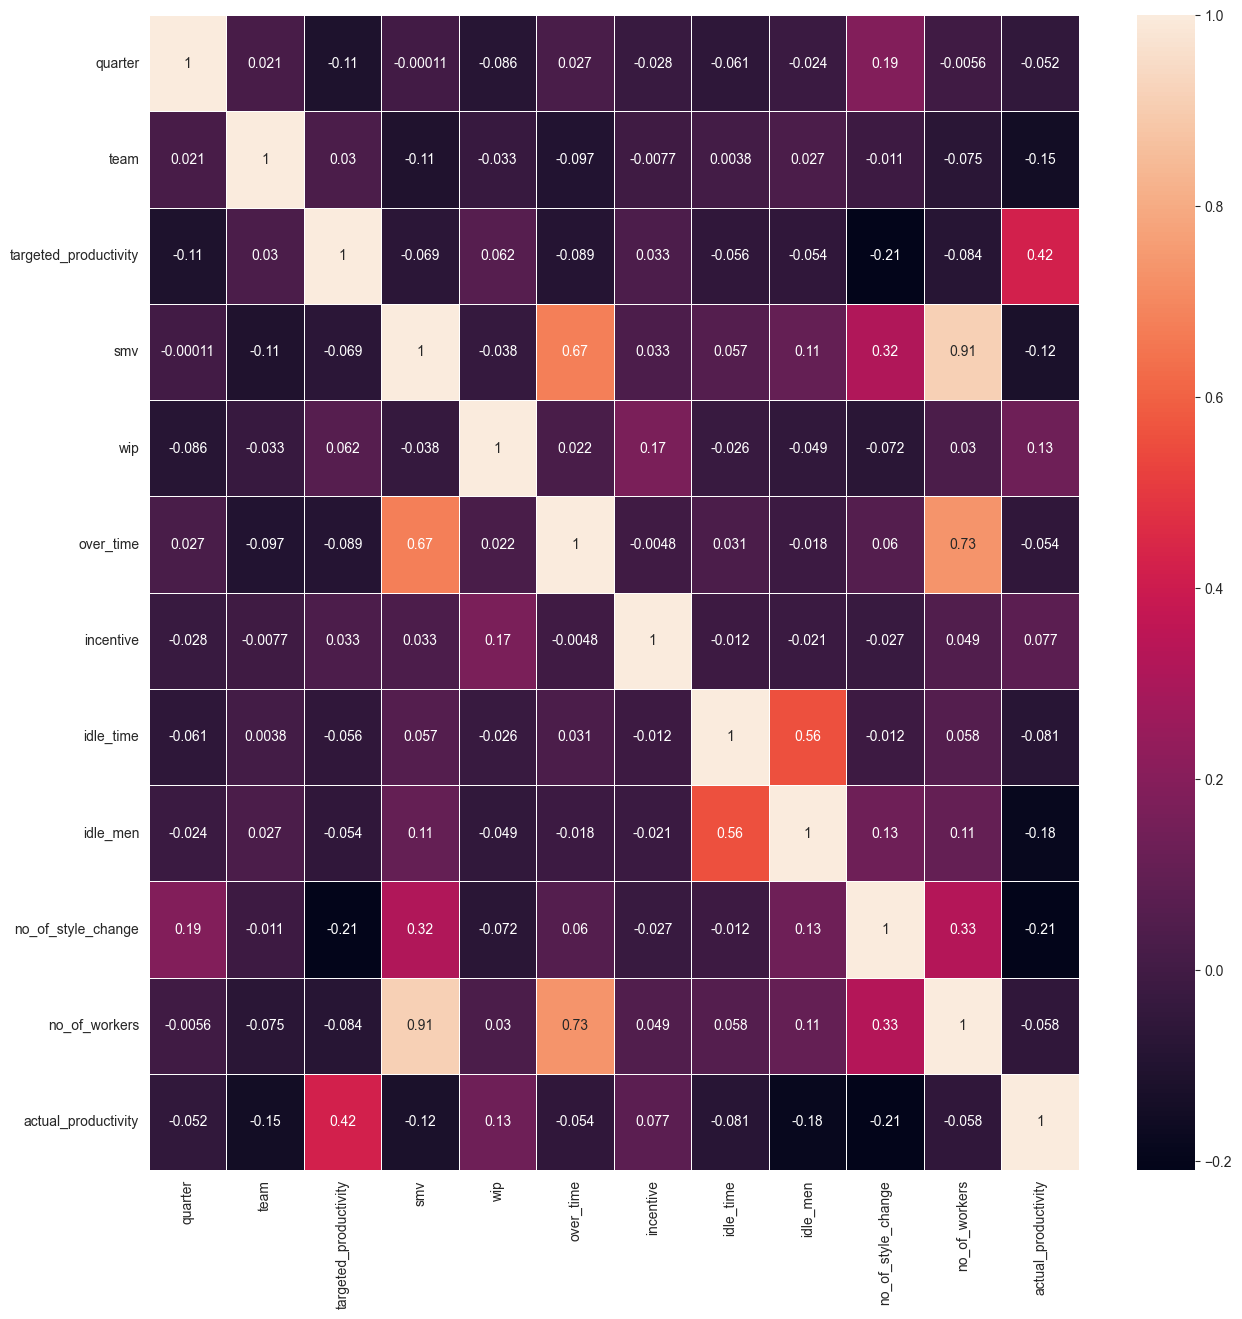

In [12]:
corrMatrix = df.corr()
fig, ax = plt.subplots(figsize=(15,15)) # Sample figsize in inches
sns.heatmap(corrMatrix, annot=True, linewidths=.5, ax=ax)
plt.savefig("covarianza.png")
plt.show()

## Limpieza de los datos

Hagamos una limpieza y un preprocesamiento de los datos antes de pasar a la predicción

In [13]:
df['date'] = pd.to_datetime(df['date'])

In [14]:
df.date

0      2015-01-01
1      2015-01-01
2      2015-01-01
3      2015-01-01
4      2015-01-01
          ...    
1192   2015-03-11
1193   2015-03-11
1194   2015-03-11
1195   2015-03-11
1196   2015-03-11
Name: date, Length: 1197, dtype: datetime64[ns]

Así que los datos que tenemos son de 3 meses. 
Optamos por dejar el dia ya que como son pocos meses es suficiente en lugar de la fecha completa.

In [15]:
df['Dia']=df['date'].dt.day
df.drop(['date'],axis=1, inplace=True)

Optamos por quitar los valores donde el "wip" era cero

In [16]:
df = df[df['wip'].notna()]

Aqui, tomaremos dos vertientes:
- Una sera la eliminacion de los valores que en la productividad actual sean mayores a 1
- Otra sera el remplazo por 1 todos aquellos valores que sobrepasen el rango de 0-1

In [17]:
#df = df.drop(df[df['actual_productivity'] > 1].index)  #Eliminación de los elementos mayores a 1

df.loc[df['actual_productivity'] > 1, 'actual_productivity'] = 1 #Remplazo del valor a los de fuera de rango

### Implementacion PCA

Con el fin de obtener mas respuestas de nuestros datos, aplicaremos PCA para ver que tanto explica la varianza nuestros datos. 

En los datos, puedes ver algunas columnas no numéricas. Así que antes de aplicar PCA vamos a codificarlas.

In [18]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [19]:
#!pip install MultiColumnLabelEncoder

In [20]:
import MultiColumnLabelEncoder

In [21]:
Mcle = MultiColumnLabelEncoder.MultiColumnLabelEncoder()
df = Mcle.fit_transform(df)

In [22]:
# Entrenamiento modelo PCA con escalado de los datos
pca_pipe = make_pipeline(StandardScaler(), PCA())
pca_pipe.fit(df)
modelo_pca = pca_pipe.named_steps['pca']# Se extrae el modelo entrenado del pipeline

In [23]:
# Se combierte el array a dataframe para añadir nombres a los ejes.
pd.DataFrame(
    data    = modelo_pca.components_,
    columns = df.columns,
    index   = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15']
)

,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity,Dia
PC1,2.454221e-01,-5.551115e-17,-2.608347e-02,4.462868e-02,-4.316220e-01,1.208496e-01,-1.468818e-01,-2.364054e-02,-4.645091e-01,1.224601e-01,2.028440e-01,0.331681,6.233030e-02,-5.175446e-01,2.457643e-01
PC2,-3.277010e-01,0.000000e+00,5.194844e-02,3.906265e-01,-3.697935e-02,-4.146391e-01,-1.595936e-02,-3.476906e-01,-2.196330e-01,1.340368e-01,1.605429e-01,-0.075319,-4.668348e-01,-1.387269e-01,-3.287195e-01
PC3,-5.053785e-01,-1.110223e-16,5.024132e-02,-2.414151e-01,-8.162237e-02,3.447092e-01,5.256463e-02,1.871496e-01,-1.240504e-01,2.527582e-01,2.234893e-01,-0.101938,3.348791e-01,-1.410559e-01,-4.988564e-01
PC4,1.928689e-01,-1.387779e-17,-2.236844e-02,-2.942540e-02,2.652352e-01,-1.676368e-02,-2.679971e-02,-1.417339e-01,1.981275e-01,6.168234e-01,6.084819e-01,0.017329,2.815275e-02,1.957972e-01,2.014761e-01
PC5,7.235147e-02,-7.632783e-17,-5.633003e-01,1.568330e-01,-1.587325e-01,-1.484326e-01,-6.505685e-02,5.465992e-01,1.607703e-02,1.784036e-01,4.452948e-03,-0.490967,-1.230759e-01,-1.076994e-01,5.223280e-02
PC6,8.055362e-02,4.597017e-17,1.769070e-01,4.716250e-02,-2.117212e-01,-1.305821e-01,9.301514e-01,1.011582e-01,4.627066e-02,8.134673e-02,3.766115e-02,-0.026401,1.506422e-02,-7.518406e-02,7.710537e-02
PC7,-6.961140e-02,2.862294e-17,-7.912802e-01,-1.875140e-01,4.750351e-02,6.161167e-03,2.458939e-01,-3.080586e-01,-1.029120e-03,-9.527798e-02,1.474471e-02,0.379353,1.273940e-02,5.967887e-02,-1.388560e-01
PC8,5.900344e-03,-1.504873e-16,8.560761e-02,-7.872272e-01,-3.574944e-01,-3.251958e-01,-1.048661e-01,-1.181109e-01,9.522978e-02,1.064479e-01,-5.007516e-02,-0.141095,-2.667099e-01,-4.549876e-03,2.093319e-02
PC9,-1.308886e-01,-5.551115e-17,4.195279e-02,1.859741e-01,-3.267478e-01,-4.802669e-01,-1.684829e-01,2.719617e-01,2.953640e-01,1.358046e-01,-5.255542e-02,0.489302,3.297678e-01,1.954108e-01,-1.093541e-01
PC10,3.796674e-02,-8.326673e-17,-8.196397e-02,2.227875e-01,-4.549225e-01,1.122127e-01,-6.021434e-02,-5.514666e-01,3.075687e-01,-1.733737e-02,-3.086549e-02,-0.410950,3.863344e-01,-5.610694e-03,3.001832e-02


----------------------------------------------------
Porcentaje de varianza explicada por cada componente
----------------------------------------------------
[1.98823978e-01 1.52817788e-01 1.42501794e-01 1.00574999e-01
 8.23451783e-02 6.98027954e-02 6.62449834e-02 5.05298712e-02
 4.15926626e-02 3.21749986e-02 3.03999430e-02 2.19442824e-02
 8.59445030e-03 1.65227523e-03 9.98281076e-35]


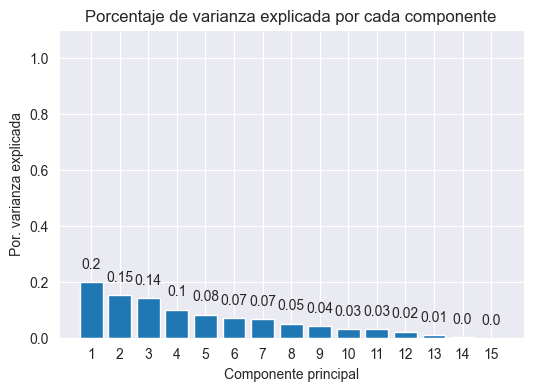

In [24]:
# Porcentaje de varianza explicada por cada componente
print('----------------------------------------------------')
print('Porcentaje de varianza explicada por cada componente')
print('----------------------------------------------------')
print(modelo_pca.explained_variance_ratio_)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
ax.bar(
    x      = np.arange(modelo_pca.n_components_) + 1,
    height = modelo_pca.explained_variance_ratio_
)

for x, y in zip(np.arange(len(df.columns)) + 1, modelo_pca.explained_variance_ratio_):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )

ax.set_xticks(np.arange(modelo_pca.n_components_) + 1)
ax.set_ylim(0, 1.1)
ax.set_title('Porcentaje de varianza explicada por cada componente')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Por. varianza explicada');

In [25]:
df.drop(['Dia'],axis=1, inplace=True)

### Escalando nuestros datos

In [26]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

#scaler = StandardScaler()
scaler = MinMaxScaler()


# standarizing data
scaled_data = scaler.fit_transform(df)


# creating dataframe with standarized features
scaled_df = pd.DataFrame(scaled_data, index=df.index, columns=df.columns)

In [27]:
scaled_df

,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,0.00,0.0,0.0,0.636364,1.000000,0.361941,0.047631,0.273148,0.710145,0.0,0.0,0.0,0.523810,0.922648
2,0.00,0.0,0.0,0.909091,1.000000,0.030555,0.041575,0.141204,0.362319,0.0,0.0,0.0,0.071429,0.739748
3,0.00,0.0,0.0,1.000000,1.000000,0.030555,0.041575,0.141204,0.362319,0.0,0.0,0.0,0.071429,0.739748
4,0.00,0.0,0.0,0.454545,1.000000,0.356100,0.050314,0.074074,0.362319,0.0,0.0,0.0,0.476190,0.739502
5,0.00,0.0,0.0,0.545455,1.000000,0.356100,0.042267,0.259259,0.275362,0.0,0.0,0.0,0.476190,0.739167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1187,0.25,0.0,1.0,0.272727,0.931507,0.376769,0.045295,0.273148,0.326087,0.0,0.0,0.0,0.523810,0.673821
1188,0.25,0.0,1.0,0.363636,0.863014,0.376769,0.042613,0.268519,0.217391,0.0,0.0,0.5,0.507937,0.609232
1189,0.25,0.0,1.0,0.636364,0.863014,0.458998,0.039239,0.263889,0.217391,0.0,0.0,0.5,0.492063,0.609165
1190,0.25,0.0,1.0,0.454545,0.863014,0.300157,0.048497,0.175926,0.289855,0.0,0.0,0.5,0.190476,0.608827


In [28]:
x = scaled_df.drop(['actual_productivity'],axis=1)
y = scaled_df['actual_productivity']

## Prediciendo la productividad

Antes de tratar de predecir, vamos a preparar los datos de entrenamiento y de prueba

In [29]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y,train_size=0.8,random_state=0)

Los algoritmos que implementaremos para ver cual se adapta mejor a los datos son los siguientes:

In [30]:
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.tree import DecisionTreeRegressor

Funcion para obtener algunas metricas de los algoritmos con nuestros datos.

In [31]:
def impresionResultados(y_test, pred6):
    print("test_MSE:",mean_squared_error(y_test, pred6))
    print("test_MAE:",mean_absolute_error(y_test, pred6))
    print("R2_score:{}".format(r2_score(y_test, pred6)))

- LinearRegression

In [32]:
model_lr=LinearRegression()

model_lr.fit(x_train,y_train)
pred_test=model_lr.predict(x_test)
impresionResultados(y_test, pred_test)

test_MSE: 0.012168407099229383
test_MAE: 0.06531525006209479
R2_score:0.7380086627295019


- XGBoost

In [34]:
model_xgb = xgb.XGBRegressor(n_estimators=200, max_depth=5, learning_rate=0.1)

model_xgb.fit(x_train, y_train)
pred3=model_xgb.predict(x_test)
impresionResultados(y_test, pred3)

test_MSE: 0.008248876624714723
test_MAE: 0.0513565096881294
R2_score:0.8223979358789512


- Decision Tree Regressor

In [37]:
dt_regressor = DecisionTreeRegressor(random_state = 0)

dt_regressor.fit(x_train,y_train)
pred7 = dt_regressor.predict(x_test)
impresionResultados(y_test, pred7)

test_MSE: 0.019689300330494486
test_MAE: 0.06989839615326952
R2_score:0.5760804120505314
